In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import pickle
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings('ignore')

In [17]:
lgbm_model = lgb.Booster(model_file='sentiment_model.txt')
print("LightGBM model loaded")

with open('label_mapping.pkl', 'rb') as f:
    label_mapping = pickle.load(f)

with open('model_info.pkl', 'rb') as f:
    model_info = pickle.load(f)

print("\nModel Configuration:")
print(f"  Sentence Transformer: {model_info['sentence_transformer_model']}")
print(f"  Embedding Dimension: {model_info['embedding_dim']}")
print(f"  Label Mapping: {model_info['label_mapping']}")

LightGBM model loaded

Model Configuration:
  Sentence Transformer: all-MiniLM-L6-v2
  Embedding Dimension: 384
  Label Mapping: {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}


In [5]:
sentence_model = SentenceTransformer(model_info['sentence_transformer_model'])
print(f" Sentence Transformer model '{model_info['sentence_transformer_model']}' loaded")

def get_embedding(text):
    """Generate embedding for a text using sentence transformer"""
    if not isinstance(text, str) or text.strip() == "":
        return np.zeros(model_info['embedding_dim'])
    return sentence_model.encode(text, convert_to_numpy=True, normalize_embeddings=True)

 Sentence Transformer model 'all-MiniLM-L6-v2' loaded


#### Loading Raw Comment Data (Without Labels)

In [6]:
comments_data = pd.read_csv("merged_hinglish_comments.csv")

comments_data = comments_data[['Post_Date', 'Ticker_Symbol', 'Post_Title', 'Comment_Text']].copy()

comments_data['Post_Date'] = pd.to_datetime(comments_data['Post_Date'])
comments_data['Date'] = comments_data['Post_Date'].dt.date

print("Comment data loaded:")
print(f"  Total comments: {len(comments_data)}")
print(f"  Date range: {comments_data['Date'].min()} to {comments_data['Date'].max()}")
print(f"  Tickers: {comments_data['Ticker_Symbol'].unique()}")
print("\nSample data:")
print(comments_data.head())

Comment data loaded:
  Total comments: 583
  Date range: 2020-05-19 to 2025-10-14
  Tickers: ['ADANIENT' 'BHARTIARTL' 'HDFCBANK' 'ICICIBANK' 'INFY' 'RELIANCE' 'SBIN'
 'TCS']

Sample data:
   Post_Date Ticker_Symbol                                         Post_Title  \
0 2023-12-30      ADANIENT  At the end of the year, I got a 46% return thi...   
1 2025-02-18      ADANIENT                     I am scared, What should I do?   
2 2025-03-21      ADANIENT                      My plan for 2 lakh investment   
3 2025-09-26      ADANIENT                  Buy now or wait ? Tell me experts   
4 2024-11-07      ADANIENT                                Rate this portfolio   

                                        Comment_Text        Date  
0  Doubled my money in adani stocks from Jan 2023...  2023-12-30  
1  If you knew what you were doing, then you shou...  2025-02-18  
2  I'd add Tatamotors and Adaniports given that t...  2025-03-21  
3  Bro, Adani Share Based on News not that Much o...  202

#### Generating Embeddings for Comments

In [7]:
comments_data['Post_Embedding'] = comments_data['Post_Title'].apply(get_embedding)
comments_data['Comment_Embedding'] = comments_data['Comment_Text'].apply(get_embedding)

comments_data['Combined_Embedding'] = comments_data.apply(
    lambda x: (x['Post_Embedding'] + x['Comment_Embedding']) / 2,
    axis=1
)

print("Embeddings generated")

Embeddings generated


In [18]:
X_predict = np.vstack(comments_data['Combined_Embedding'].values)

predictions_proba = lgbm_model.predict(X_predict)

predicted_labels = np.argmax(predictions_proba, axis=1)

comments_data['Predicted_Sentiment_Numeric'] = predicted_labels
comments_data['Predicted_Sentiment'] = comments_data['Predicted_Sentiment_Numeric'].map(label_mapping)

comments_data['Prediction_Confidence'] = np.max(predictions_proba, axis=1)

print("\nPredicted Sentiment Distribution:")
print(comments_data['Predicted_Sentiment'].value_counts())
print(f"\nAverage Prediction Confidence: {comments_data['Prediction_Confidence'].mean():.2%}")

print("\nSample predictions:")
print(comments_data[['Post_Title', 'Comment_Text', 'Predicted_Sentiment', 'Prediction_Confidence']].head(10))


Predicted Sentiment Distribution:
Predicted_Sentiment
Bullish    438
Neutral     99
Bearish     46
Name: count, dtype: int64

Average Prediction Confidence: 64.41%

Sample predictions:
                                          Post_Title  \
0  At the end of the year, I got a 46% return thi...   
1                     I am scared, What should I do?   
2                      My plan for 2 lakh investment   
3                  Buy now or wait ? Tell me experts   
4                                Rate this portfolio   
5                                Rate this portfolio   
6                                 Months of research   
7  30 M , can you guys rate my portfolio and how ...   
8  30 M , can you guys rate my portfolio and how ...   
9  30 M , can you guys rate my portfolio and how ...   

                                        Comment_Text Predicted_Sentiment  \
0  Doubled my money in adani stocks from Jan 2023...             Bullish   
1  If you knew what you were doing, then you 

#### Predictions to Sentiment Scores

In [ ]:
sentiment_score_mapping = {
    'Bearish': -1,
    'Neutral': 0,
    'Bullish': 1
}

comments_data['Sentiment_Score'] = comments_data['Predicted_Sentiment'].map(sentiment_score_mapping)

daily_sentiment = comments_data.groupby(['Date', 'Ticker_Symbol']).agg({
    'Sentiment_Score': 'mean',  
    'Predicted_Sentiment': 'count',  
    'Prediction_Confidence': 'mean'  
}).reset_index()

daily_sentiment.columns = ['Date', 'Ticker_Symbol', 'Avg_Sentiment_Score', 'Comment_Count', 'Avg_Confidence']

print("Daily aggregated predicted sentiment:")
print(daily_sentiment.head(10))
print(f"\nShape: {daily_sentiment.shape}")
print(f"\nSentiment score range: {daily_sentiment['Avg_Sentiment_Score'].min():.2f} to {daily_sentiment['Avg_Sentiment_Score'].max():.2f}")
print(f"\nSample sentiment distribution:")
print(f"  Positive (>0.3): {(daily_sentiment['Avg_Sentiment_Score'] > 0.3).sum()} days")
print(f"  Neutral (-0.3 to 0.3): {((daily_sentiment['Avg_Sentiment_Score'] >= -0.3) & (daily_sentiment['Avg_Sentiment_Score'] <= 0.3)).sum()} days")
print(f"  Negative (<-0.3): {(daily_sentiment['Avg_Sentiment_Score'] < -0.3).sum()} days")

Daily aggregated predicted sentiment:
         Date Ticker_Symbol  Avg_Sentiment_Score  Comment_Count  \
0  2020-05-19    BHARTIARTL                  0.0              2   
1  2020-11-16      HDFCBANK                  1.0              1   
2  2020-11-16     ICICIBANK                  1.0              1   
3  2020-11-18      HDFCBANK                  1.0              4   
4  2020-11-18     ICICIBANK                  1.0              1   
5  2020-11-18          SBIN                  1.0              3   
6  2020-12-03      HDFCBANK                  1.0              5   
7  2020-12-03          SBIN                  1.0              2   
8  2020-12-20      HDFCBANK                  1.0              1   
9  2020-12-20     ICICIBANK                  1.0              2   

   Avg_Confidence  
0        0.501954  
1        0.806544  
2        0.908233  
3        0.586199  
4        0.524334  
5        0.717386  
6        0.715520  
7        0.710557  
8        0.905856  
9        0.912342  

Sha

In [ ]:
stock_data = pd.read_csv("merged_stock_history.csv")

stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data['Date'] = stock_data['Date'].dt.date

print("Stock price data loaded:")
print(stock_data.head())
print(f"\nShape: {stock_data.shape}")
print(f"\nDate range: {stock_data['Date'].min()} to {stock_data['Date'].max()}")
print(f"\nTickers: {stock_data['Ticker_Symbol'].unique()}")

Stock price data loaded:
         Date         Open         High          Low        Close   Volume  \
0  2024-10-08  3016.957435  3168.380013  2993.319619  3159.084717  1776511   
1  2024-10-09  3173.377323  3178.324745  3132.797975  3152.138184   897335   
2  2024-10-10  3138.395406  3209.359124  3054.538378  3172.577881  2905725   
3  2024-10-11  3172.577771  3188.369745  3114.407563  3135.596680  1035260   
4  2024-10-14  3143.392850  3148.490341  3091.269597  3099.515381   437728   

   Dividends  Stock Splits Ticker_Symbol  
0        0.0           0.0      ADANIENT  
1        0.0           0.0      ADANIENT  
2        0.0           0.0      ADANIENT  
3        0.0           0.0      ADANIENT  
4        0.0           0.0      ADANIENT  

Shape: (2057, 9)

Date range: 2024-10-03 to 2025-10-17

Tickers: ['ADANIENT' 'BHARTIARTL' 'HDFCBANK' 'ICICIBANK' 'INFY' 'RELIANCE' 'SBIN'
 'TCS']


In [ ]:
merged_data = pd.merge(
    stock_data,
    daily_sentiment,
    on=['Date', 'Ticker_Symbol'],
    how='left'  
)

merged_data['Avg_Sentiment_Score'].fillna(0, inplace=True)
merged_data['Comment_Count'].fillna(0, inplace=True)
merged_data['Avg_Confidence'].fillna(0, inplace=True)

merged_data = merged_data.sort_values(['Ticker_Symbol', 'Date']).reset_index(drop=True)
merged_data['Price_Change_Pct'] = merged_data.groupby('Ticker_Symbol')['Close'].pct_change() * 100

print("Merged data:")
print(merged_data.head(10))
print(f"\nShape: {merged_data.shape}")
print(f"\nDays with comments: {(merged_data['Comment_Count'] > 0).sum()}")
print(f"\nDays without comments: {(merged_data['Comment_Count'] == 0).sum()}")

Merged data:
         Date         Open         High          Low        Close   Volume  \
0  2024-10-08  3016.957435  3168.380013  2993.319619  3159.084717  1776511   
1  2024-10-09  3173.377323  3178.324745  3132.797975  3152.138184   897335   
2  2024-10-10  3138.395406  3209.359124  3054.538378  3172.577881  2905725   
3  2024-10-11  3172.577771  3188.369745  3114.407563  3135.596680  1035260   
4  2024-10-14  3143.392850  3148.490341  3091.269597  3099.515381   437728   
5  2024-10-15  3122.403467  3126.401422  3089.920076  3103.113281   371613   
6  2024-10-16  3096.416667  3113.807677  3059.435577  3084.322754   543476   
7  2024-10-17  3088.370723  3098.415636  2991.470322  3012.209717  2655289   
8  2024-10-18  2988.471953  3030.150593  2966.583243  3000.465820   796339   
9  2024-10-21  3003.614187  3013.409228  2915.459309  2936.148682  1051690   

   Dividends  Stock Splits Ticker_Symbol  Avg_Sentiment_Score  Comment_Count  \
0        0.0           0.0      ADANIENT        

In [19]:
print("Predicted Sentiment vs Stock Price Movements")

correlation_results = []

for ticker in merged_data['Ticker_Symbol'].unique():
    ticker_data = merged_data[merged_data['Ticker_Symbol'] == ticker].copy()
    
    ticker_with_comments = ticker_data[ticker_data['Comment_Count'] > 0].copy()
    
    if len(ticker_with_comments) > 1:
        corr = ticker_with_comments['Avg_Sentiment_Score'].corr(ticker_with_comments['Price_Change_Pct'])
        
        correlation_results.append({
            'Ticker': ticker,
            'Correlation': corr,
            'Days_with_Comments': len(ticker_with_comments),
            'Avg_Sentiment': ticker_with_comments['Avg_Sentiment_Score'].mean(),
            'Avg_Confidence': ticker_with_comments['Avg_Confidence'].mean(),
            'Total_Comments': ticker_with_comments['Comment_Count'].sum()
        })

corr_df = pd.DataFrame(correlation_results).sort_values('Correlation', ascending=False)
print("\n", corr_df.to_string(index=False))

overall_corr = merged_data[merged_data['Comment_Count'] > 0]['Avg_Sentiment_Score'].corr(
    merged_data[merged_data['Comment_Count'] > 0]['Price_Change_Pct']
)
print(f" Correlation for all tickers: {overall_corr:.4f}")

Predicted Sentiment vs Stock Price Movements

     Ticker  Correlation  Days_with_Comments  Avg_Sentiment  Avg_Confidence  Total_Comments
 ICICIBANK     0.804707                   4       0.750000        0.441227             4.0
  RELIANCE     0.212796                  30       0.637179        0.621600            72.0
      INFY     0.175756                   6       0.333333        0.582683             6.0
       TCS     0.132143                  12       0.916667        0.625012            20.0
  ADANIENT    -0.072418                  22       0.478535        0.630497            39.0
BHARTIARTL    -0.881425                   5       0.400000        0.525812             7.0
  HDFCBANK          NaN                  12       1.000000        0.738388            15.0
 Correlation for all tickers: 0.0207


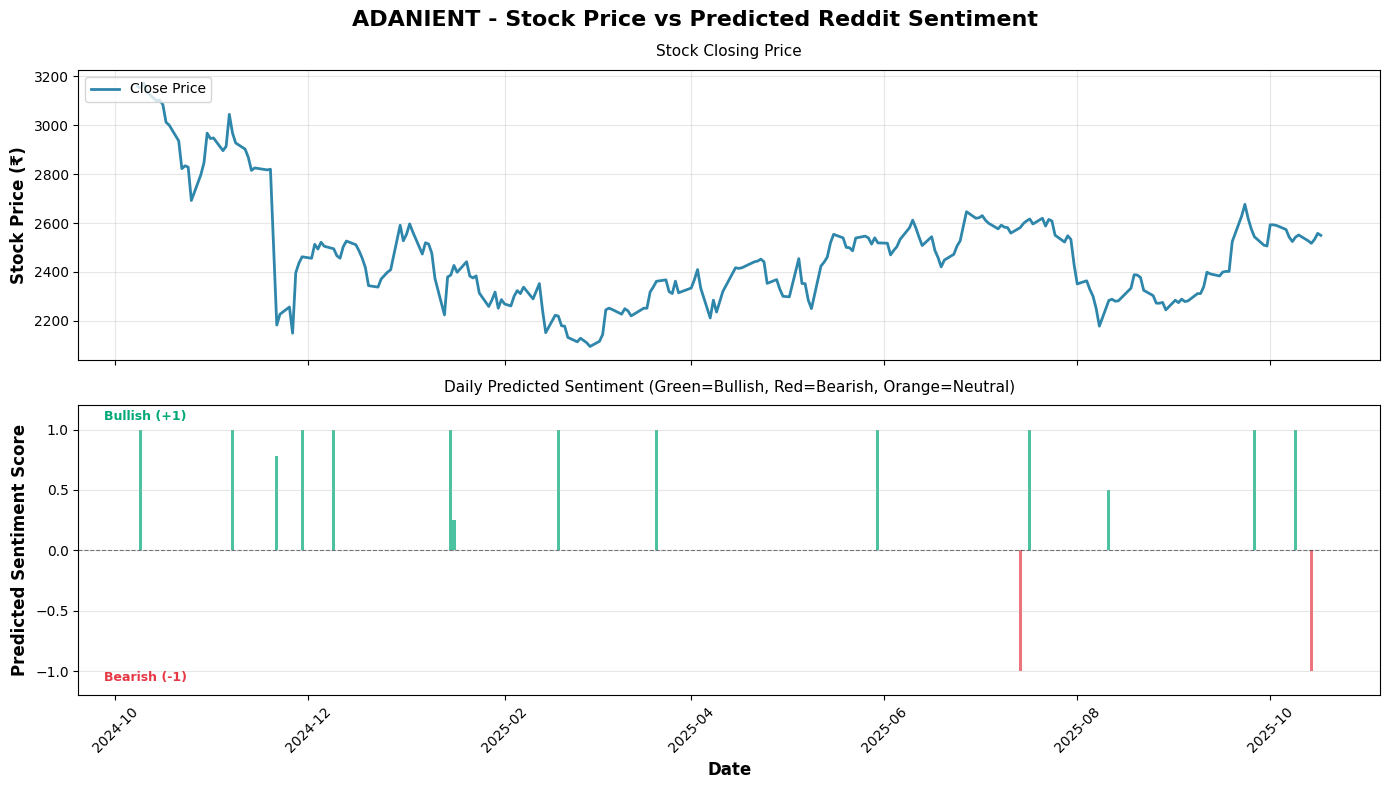


ADANIENT Statistics:
  Total trading days: 259
  Days with Reddit comments: 22
  Total comments: 39
  Average predicted sentiment: 0.479
  Average prediction confidence: 63.05%
  Price change during period: -19.30%


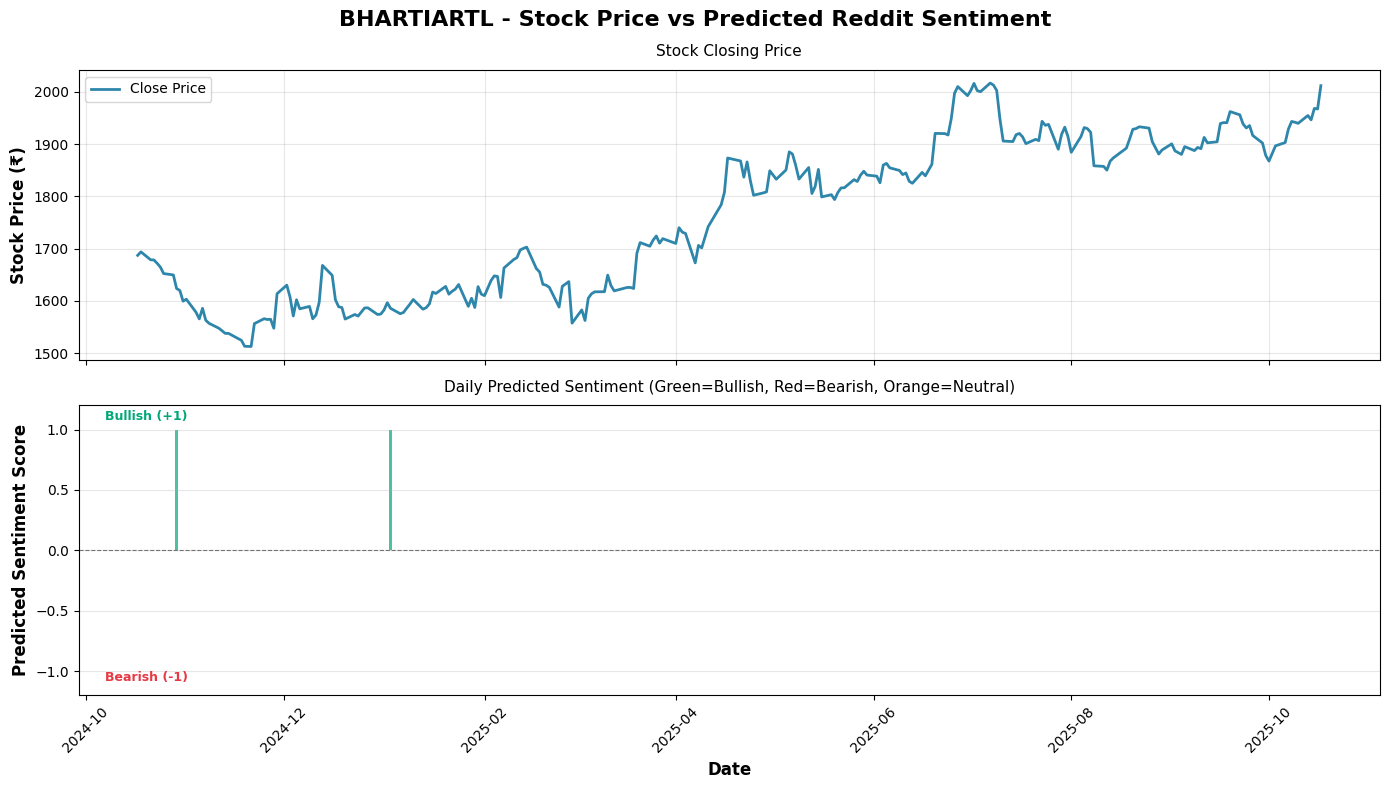


BHARTIARTL Statistics:
  Total trading days: 250
  Days with Reddit comments: 5
  Total comments: 7
  Average predicted sentiment: 0.400
  Average prediction confidence: 52.58%
  Price change during period: 19.26%


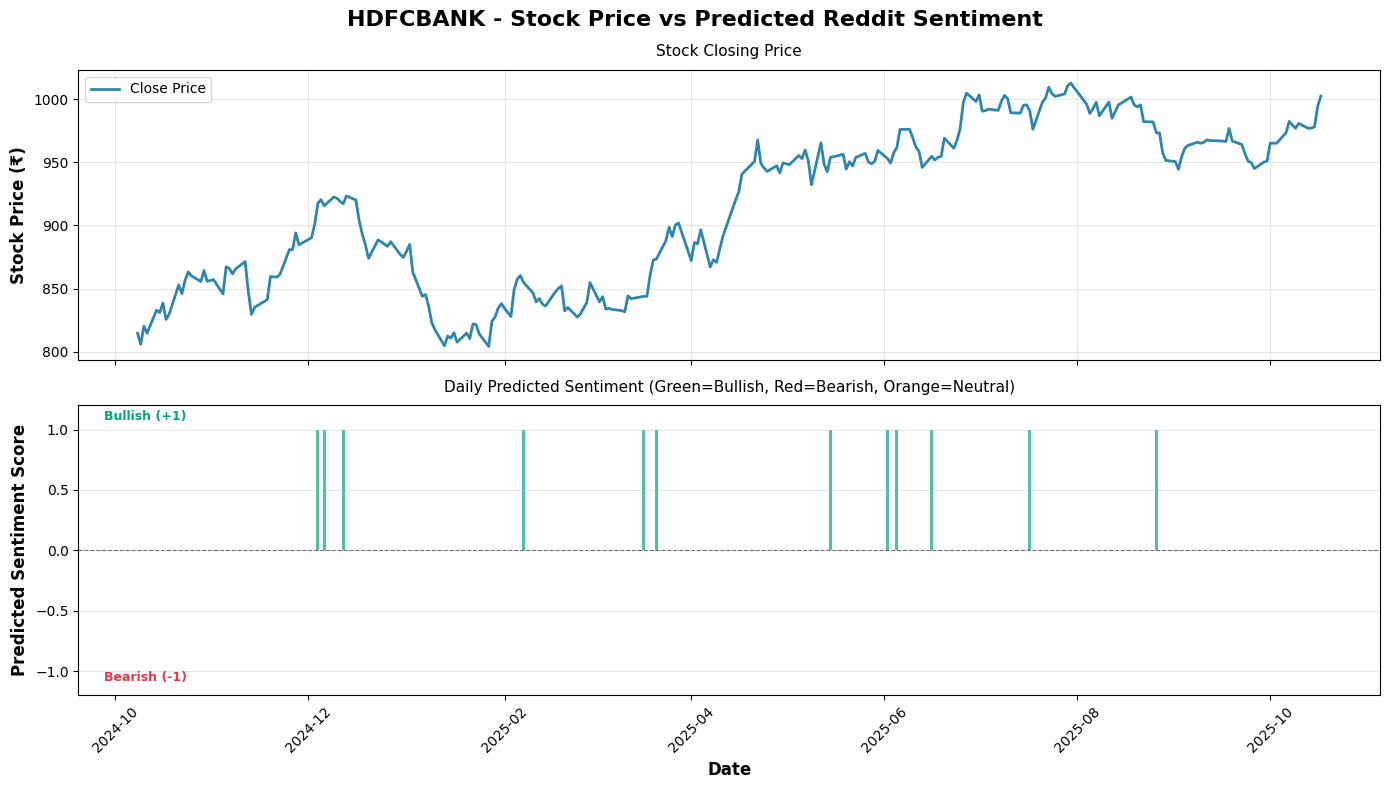


HDFCBANK Statistics:
  Total trading days: 259
  Days with Reddit comments: 12
  Total comments: 15
  Average predicted sentiment: 1.000
  Average prediction confidence: 73.84%
  Price change during period: 23.09%


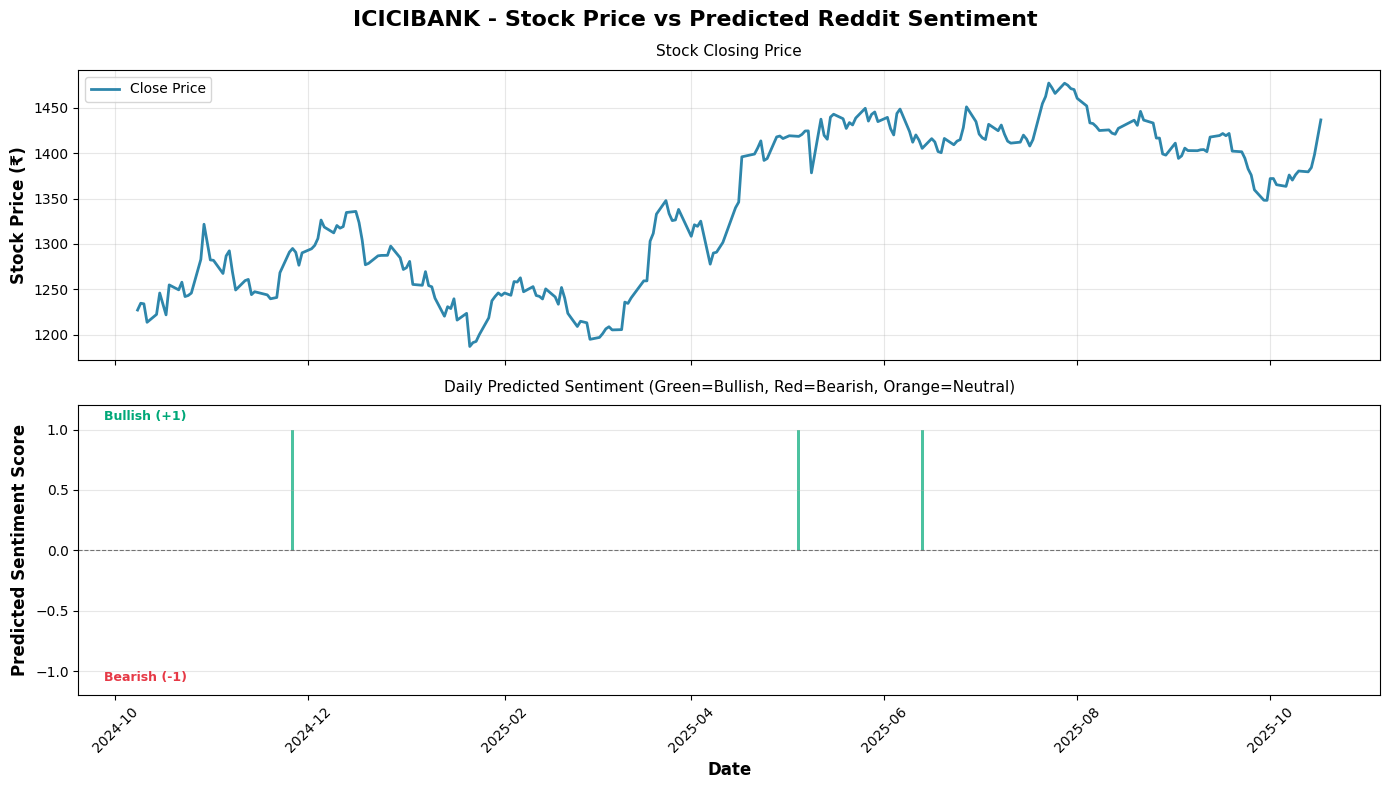


ICICIBANK Statistics:
  Total trading days: 259
  Days with Reddit comments: 4
  Total comments: 4
  Average predicted sentiment: 0.750
  Average prediction confidence: 44.12%
  Price change during period: 17.07%


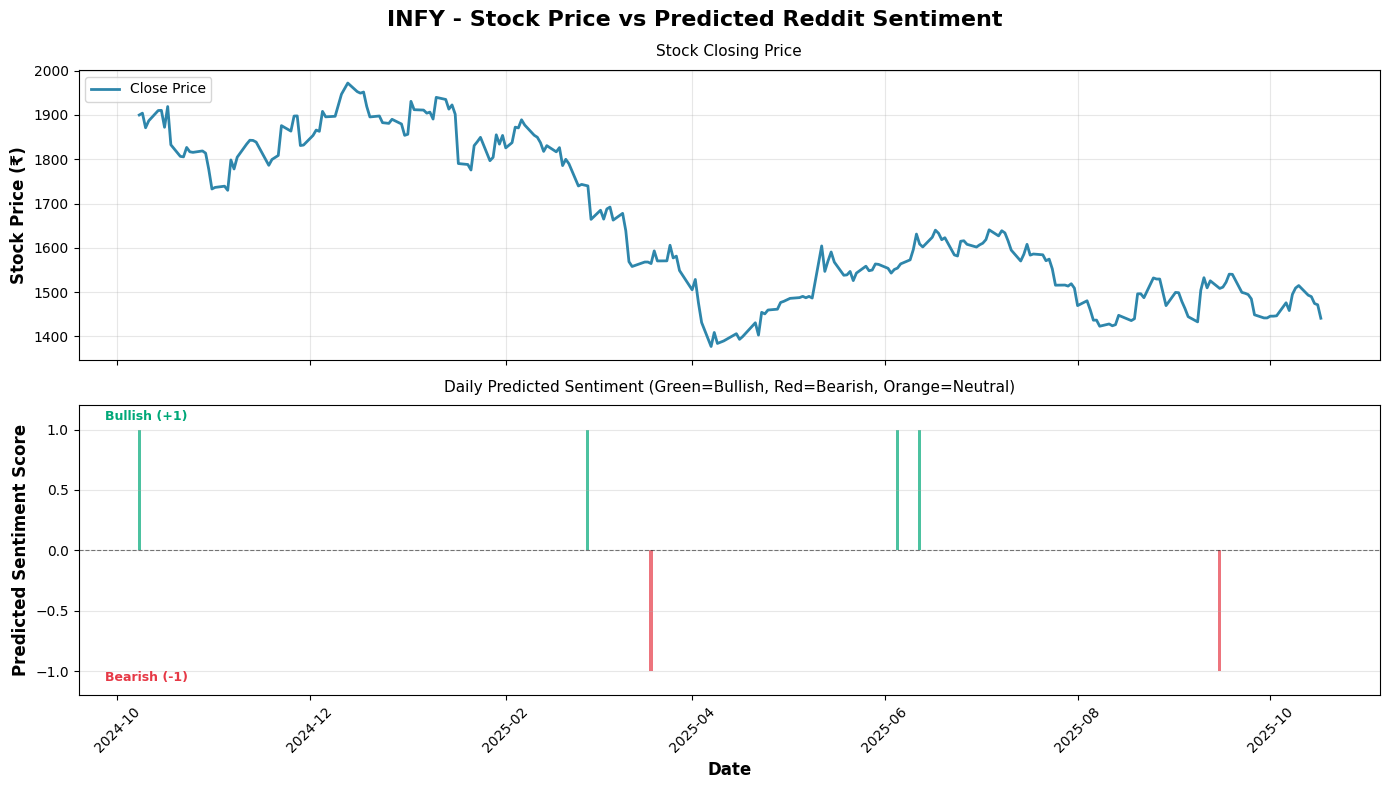


INFY Statistics:
  Total trading days: 259
  Days with Reddit comments: 6
  Total comments: 6
  Average predicted sentiment: 0.333
  Average prediction confidence: 58.27%
  Price change during period: -24.15%


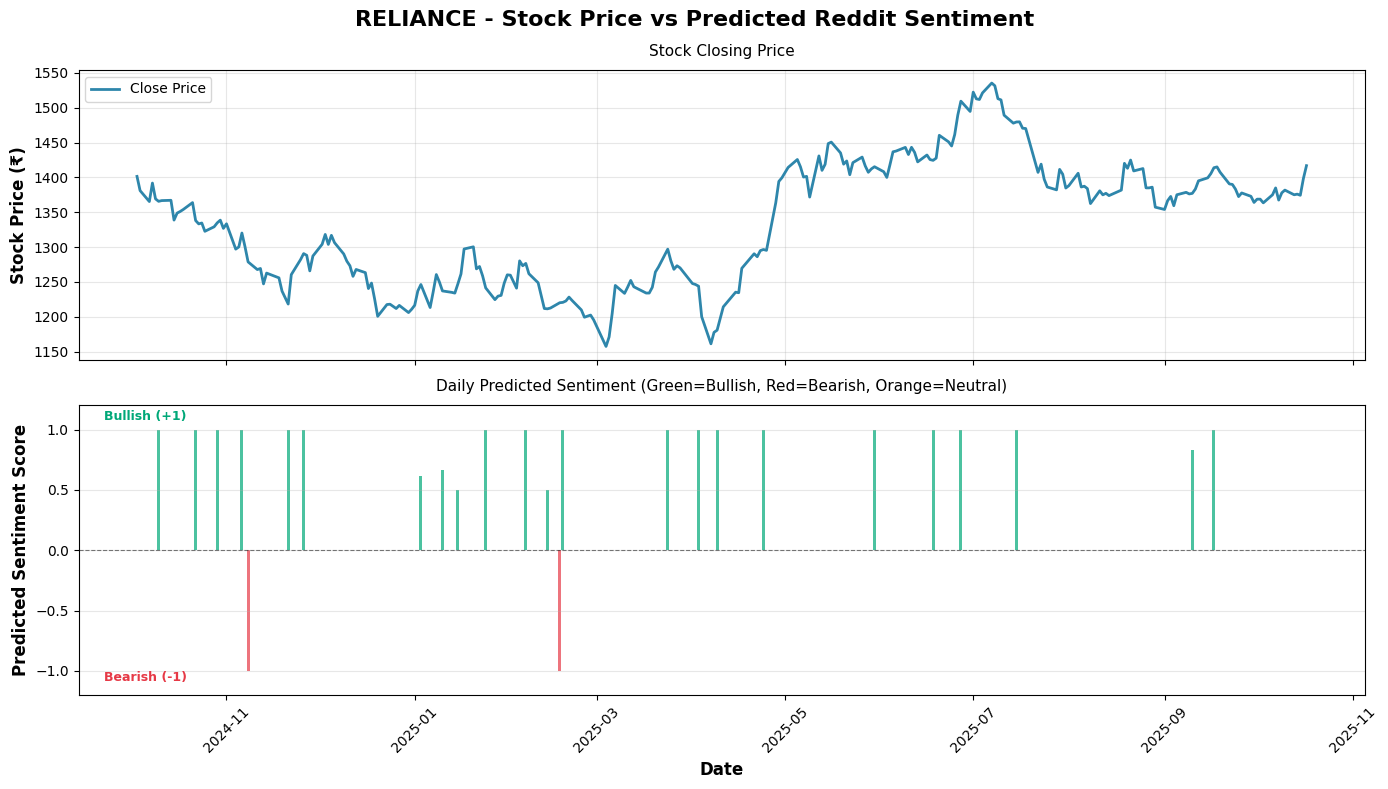


RELIANCE Statistics:
  Total trading days: 262
  Days with Reddit comments: 30
  Total comments: 72
  Average predicted sentiment: 0.637
  Average prediction confidence: 62.16%
  Price change during period: 1.10%


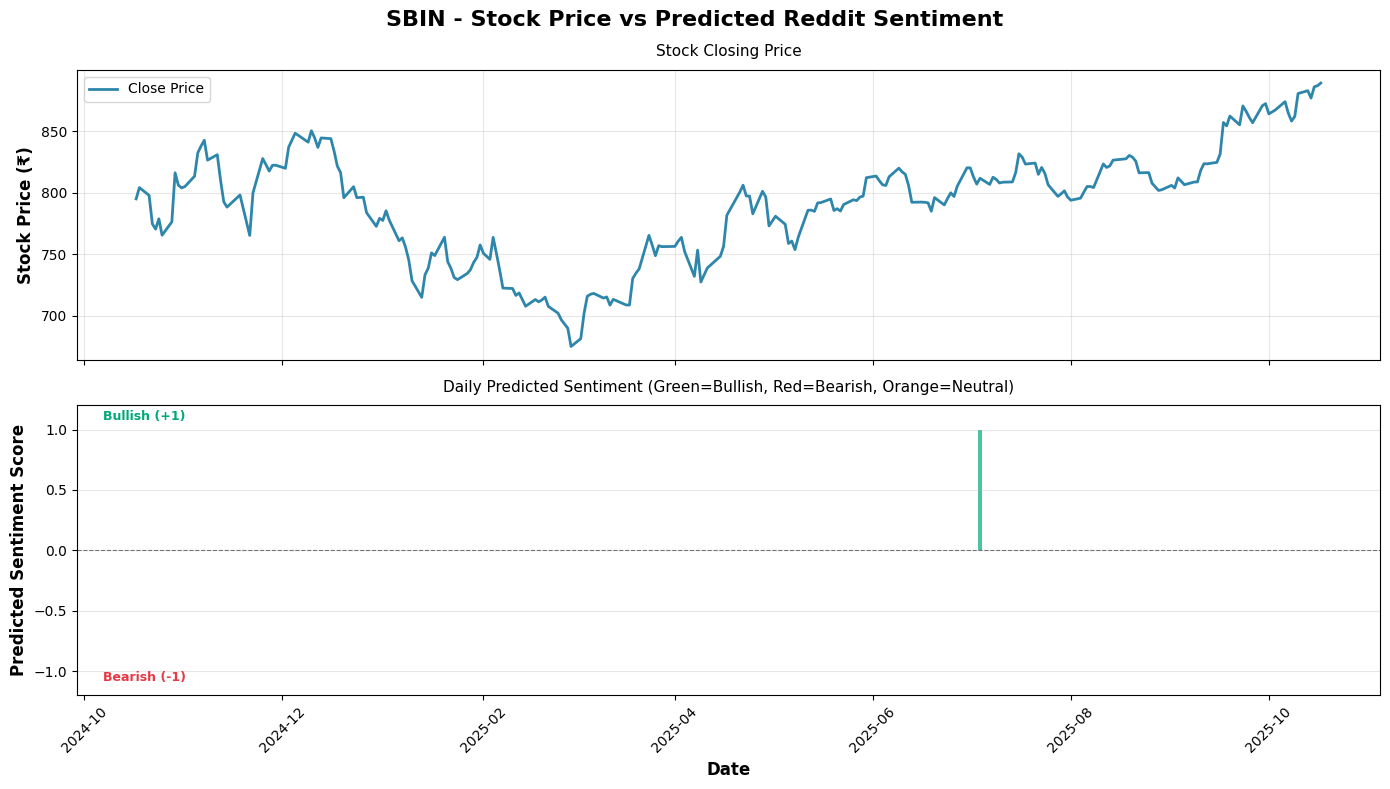


SBIN Statistics:
  Total trading days: 250
  Days with Reddit comments: 1
  Total comments: 1
  Average predicted sentiment: 1.000
  Average prediction confidence: 61.69%
  Price change during period: 11.83%


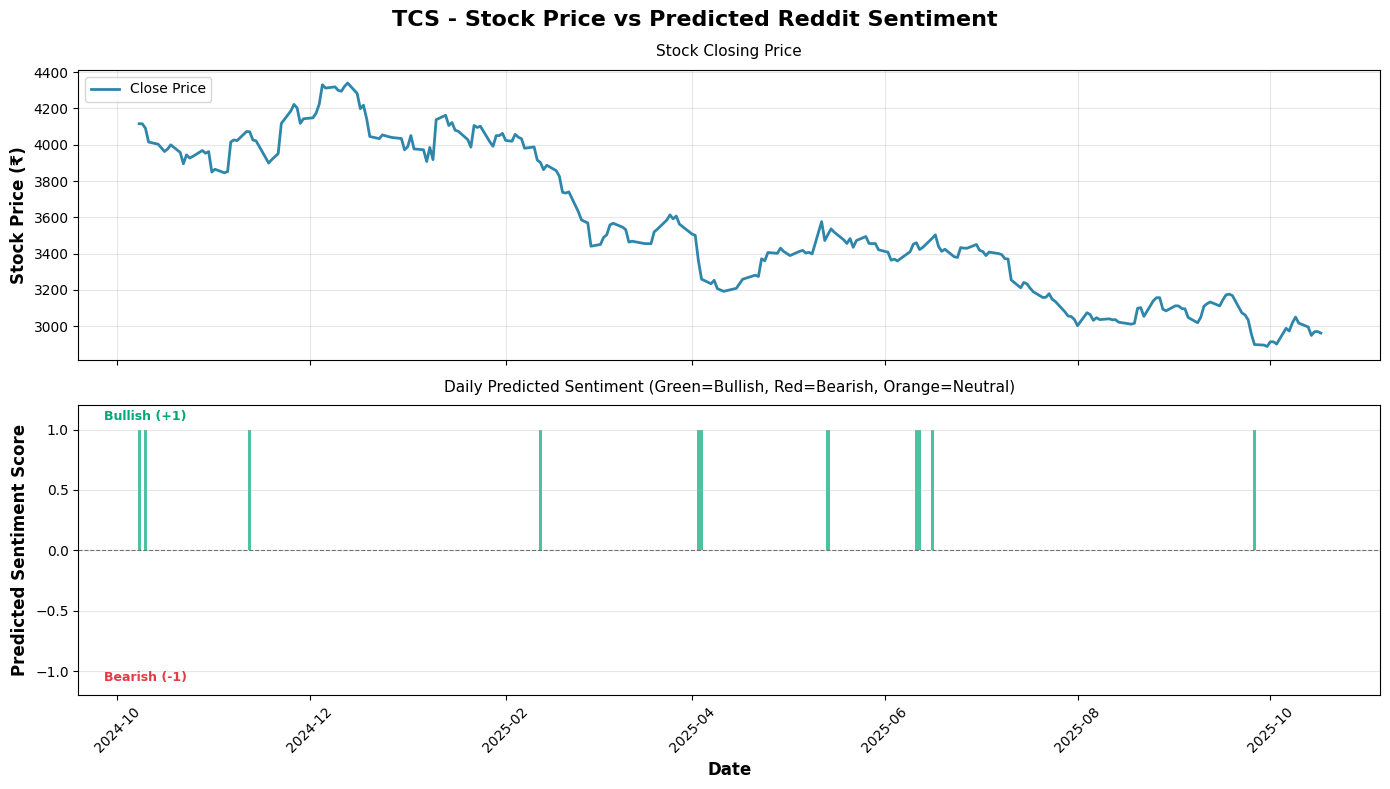


TCS Statistics:
  Total trading days: 259
  Days with Reddit comments: 12
  Total comments: 20
  Average predicted sentiment: 0.917
  Average prediction confidence: 62.50%
  Price change during period: -28.02%


In [20]:
import matplotlib.dates as mdates
from datetime import datetime

merged_data['Date'] = pd.to_datetime(merged_data['Date'])

tickers = merged_data['Ticker_Symbol'].unique()

for ticker in tickers:
    ticker_data = merged_data[merged_data['Ticker_Symbol'] == ticker].copy()
    ticker_data = ticker_data.sort_values('Date')
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    fig.suptitle(f'{ticker} - Stock Price vs Predicted Reddit Sentiment', fontsize=16, fontweight='bold')
    
    ax1.plot(ticker_data['Date'], ticker_data['Close'], 
             color='#2E86AB', linewidth=2, label='Close Price')
    ax1.set_ylabel('Stock Price (₹)', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left')
    ax1.set_title('Stock Closing Price', fontsize=11, pad=10)
    
    sentiment_days = ticker_data[ticker_data['Comment_Count'] > 0].copy()
    
    colors = sentiment_days['Avg_Sentiment_Score'].apply(
        lambda x: '#00A878' if x > 0.2 else ('#E63946' if x < -0.2 else '#F4A261')
    )
    
    ax2.bar(sentiment_days['Date'], sentiment_days['Avg_Sentiment_Score'], 
            color=colors, alpha=0.7, width=1, label='Predicted Sentiment')
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    ax2.set_ylabel('Predicted Sentiment Score', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax2.set_ylim(-1.2, 1.2)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_title('Daily Predicted Sentiment (Green=Bullish, Red=Bearish, Orange=Neutral)', 
                  fontsize=11, pad=10)
    
    ax2.text(0.02, 0.95, 'Bullish (+1)', transform=ax2.transAxes, 
             color='#00A878', fontweight='bold', fontsize=9)
    ax2.text(0.02, 0.05, 'Bearish (-1)', transform=ax2.transAxes, 
             color='#E63946', fontweight='bold', fontsize=9)
    
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    ticker_with_comments = ticker_data[ticker_data['Comment_Count'] > 0]
    if len(ticker_with_comments) > 0:
        print(f"\n{ticker} Statistics:")
        print(f"  Total trading days: {len(ticker_data)}")
        print(f"  Days with Reddit comments: {len(ticker_with_comments)}")
        print(f"  Total comments: {int(ticker_with_comments['Comment_Count'].sum())}")
        print(f"  Average predicted sentiment: {ticker_with_comments['Avg_Sentiment_Score'].mean():.3f}")
        print(f"  Average prediction confidence: {ticker_with_comments['Avg_Confidence'].mean():.2%}")
        print(f"  Price change during period: {((ticker_data['Close'].iloc[-1] - ticker_data['Close'].iloc[0]) / ticker_data['Close'].iloc[0] * 100):.2f}%")